In [1]:
import numpy as np 
import pandas as pd 
import os 

import statistics

import datetime
import matplotlib.dates as mdates
import seaborn as sns

from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
from plotting import fancyplot as fplot

### Import data

In [2]:
SO_detail = pd.read_csv("Data/Sales_SalesOrderDetail.csv", sep = ";")
SO_header = pd.read_csv("Data/Sales_SalesOrderHeader.csv", sep = ";")
SO_header_SalesReason = pd.read_csv("Data/Sales_SalesOrderHeaderSalesReason.csv", sep = ";")

Sales_customer = pd.read_csv("Data/Sales_Customer.csv", sep = ";")
Sales_territory = pd.read_csv("Data/Sales_SalesTerritory.csv", sep = ";")
Sales_reason = pd.read_csv("Data/Sales_SalesReason.csv", sep = ";")

Person_person = pd.read_csv("Data/Person_Person.csv", sep = ";")
Person_BusinessEntityContact = pd.read_csv("Data/Person_BusinessEntityContact.csv", sep = ";")

Purchasing_ShipMethod = pd.read_csv("Data/Purchasing_ShipMethod.csv", sep = ";")

Production_product = pd.read_csv("Data/Production_Product.csv", sep = ";")

In [3]:
# convert to date 
SO_header["OrderDate"] = pd.to_datetime(SO_header["OrderDate"], format = "%Y-%m-%d")
SO_header["DueDate"] = pd.to_datetime(SO_header["DueDate"], format = "%Y-%m-%d")
SO_header["ShipDate"] = pd.to_datetime(SO_header["ShipDate"], format = "%Y-%m-%d")
SO_header["ModifiedDate"] = pd.to_datetime(SO_header["ModifiedDate"], format = "%Y-%m-%d")

SO_detail["ModifiedDate"] = pd.to_datetime(SO_detail["ModifiedDate"], format = "%Y-%m-%d")

In [4]:
# Change Sales_territory a bit (will be handy later on)
Sales_territory["TerritoryName_ext"] = Sales_territory["CountryRegionCode"] + "_" + Sales_territory["Name"]

# Change Sales_reason a bit (will be handy later on)
Sales_reason = Sales_reason.rename(columns = {"Name" : "SalesReasonName"})

# Change Production_product a bit (will be handy later on)
Production_product = Production_product.rename(columns = {"Name" : "ProductName"})

In [5]:
# merge dataframes (will be useful later) 
SO = pd.merge(SO_header, SO_detail, how = 'left', on = 'SalesOrderID').merge(
    Sales_territory[["TerritoryID", "TerritoryName_ext"]], how = "left", on = "TerritoryID").merge( # Add territory information
    SO_header_SalesReason[["SalesOrderID", "SalesReasonID"]], how = "left", on = "SalesOrderID").merge( # Add the sales reason in two steps
    Sales_reason[["SalesReasonID", "SalesReasonName"]], how = "left", on = "SalesReasonID").merge(
    Production_product[["ProductID", "ProductName"]], how = "left", on = "ProductID")

### 1. How do the monetary sales evolve over time?

In [6]:
# Group the monetary sales by day
monetary_sales = SO_header[["OrderDate", "TotalDue"]].groupby("OrderDate").sum().reset_index()
monetary_sales = monetary_sales.rename(columns = {'TotalDue' : 'sumTotalDue'})
monetary_sales = monetary_sales.sort_values(by = "OrderDate")

In [7]:
# Check the first and last day we registered sales
print("First date is: ", str(np.min(monetary_sales["OrderDate"]))[0:10])
print("Last date is: ", str(np.max(monetary_sales["OrderDate"]))[0:10])

First date is:  2011-05-31
Last date is:  2014-06-30


D:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


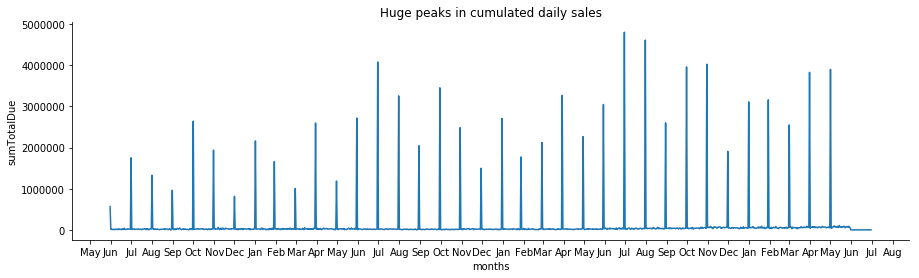

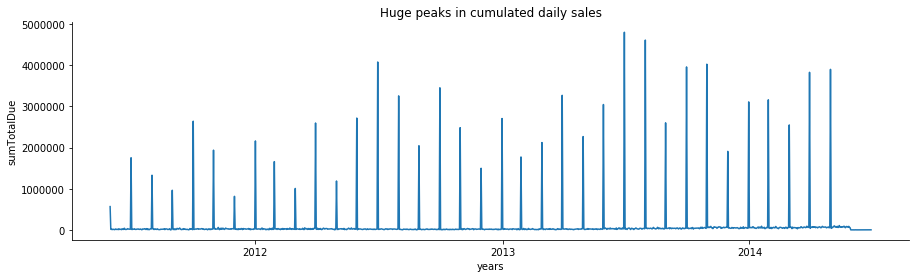

In [8]:
# plot the daily sales over time.

# This plot generates monthly xticks
fplot.plot_timeseries(x_values = monetary_sales['OrderDate'], 
                y_values = monetary_sales['sumTotalDue'], 
                x_formatting = 'months',
                y_label = "sumTotalDue",
                title = "Huge peaks in cumulated daily sales")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = monetary_sales['OrderDate'], 
                y_values = monetary_sales['sumTotalDue'], 
                x_formatting = 'years',
                y_label = "sumTotalDue",
                title = "Huge peaks in cumulated daily sales")

We see that there is a spike at the end of every month. However, there seem to be a lot of days where nothing is sold


In [9]:
# Check if the sumTotalDue is often 0 or not.
monetary_sales[monetary_sales['sumTotalDue'] ==  0].shape[0]

0

In [10]:
# Alternatively, we could check it by using the monetary_sales dataframe we created earlier
# If there are many days without sales, then we should find many occurrences where sumTotalDue = 0 in the following dataframe:
sumTotalDue_counts = monetary_sales['sumTotalDue'].value_counts().reset_index()
sumTotalDue_counts.columns = ['sumTotalDue', 'occurrence']
sumTotalDue_counts = sumTotalDue_counts.sort_values(by = 'sumTotalDue', ascending = True)
sumTotalDue_counts.head()

,sumTotalDue,occurrence
326,772.5036,1
620,1049.3527,1
298,1155.3888,1
792,1274.4858,1
766,1360.9299,1


Apparently, this is not the case. It seems like there are some steady sales, with some peaks at the end of the month. So, let's take a look at when these peaks are exactly happening. 

In [11]:
spikes = monetary_sales.sort_values(by = "sumTotalDue", ascending = False).head(36)
spikes.sort_values(by = "OrderDate").head()

,OrderDate,sumTotalDue
0,2011-05-31,5.670209e+05
31,2011-07-01,1.752611e+06
61,2011-08-01,1.328936e+06
90,2011-08-31,9.637486e+05
120,2011-10-01,2.640560e+06


The spikes are always around the end of the month. Let's see if we find a similar pattern for the discounts in the next section. However, to finish up this section, let's create one last plot of the monetary sales where we try to ignore the large spikes. 

In [12]:
# First, get 90% to get some indication about how to set y_lim 
summary = monetary_sales.describe().reset_index()
Q1 = list(summary[summary['index'] == "25%"]['sumTotalDue'])[0]
Q2 = list(summary[summary['index'] == "50%"]['sumTotalDue'])[0]
Q3 = list(summary[summary['index'] == "75%"]['sumTotalDue'])[0]
perc_95 = np.percentile(monetary_sales['sumTotalDue'], 95)

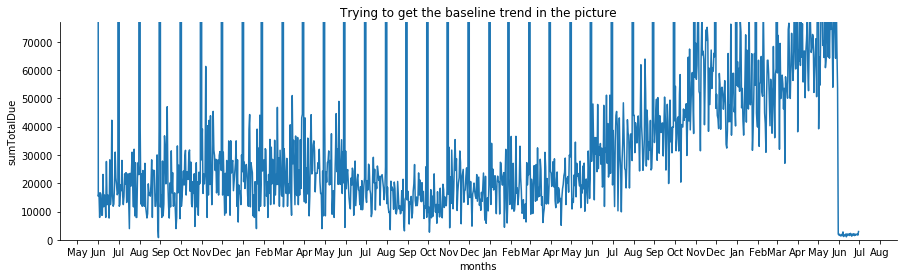

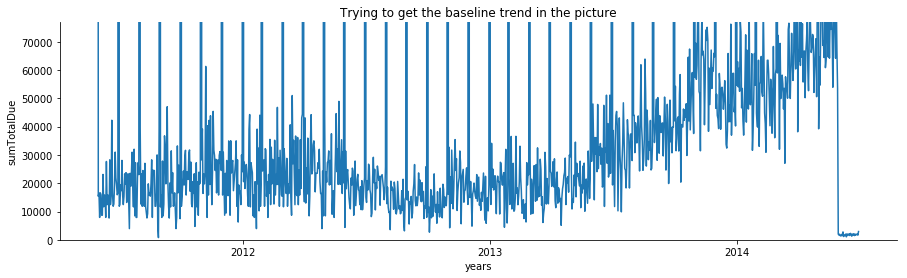

In [13]:
# This plot generates monthly xticks
fplot.plot_timeseries(x_values = monetary_sales['OrderDate'], 
                y_values = monetary_sales['sumTotalDue'], 
                x_formatting = 'months',
               ylim = (-1, perc_95),
               y_label = "sumTotalDue",
               title = "Trying to get the baseline trend in the picture")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = monetary_sales['OrderDate'], 
                y_values = monetary_sales['sumTotalDue'], 
                x_formatting = 'years',
                ylim = (-1, perc_95),
                y_label = "sumTotalDue",
                title = "Trying to get the baseline trend in the picture")

That's not really pretty, but we can finally see what is going on. There is some interesting behaviour in the sales, which is characterized by some baseline sales pattern, interrupted by some large peaks at the end of each month (or occasionally on the first day of the next month). Another interesting (and maybe more alarming) observation is the fact that the sales dropped tremendously on June 2014. 

In a final plot. We will take out the spikes (by replacing them with the mean value for the sales) and plot the sales again. Note that this plot does not contain the real sales; yet it allows us to get rid of some spikes.

In [14]:
# Make the spikes NaN
monetary_sales["sumTotalDueAdj"] = monetary_sales["sumTotalDue"].apply(lambda x: np.nan if x in set(spikes['sumTotalDue']) else x)

# Fill NaN values with previous value
monetary_sales = monetary_sales.fillna(method='backfill')

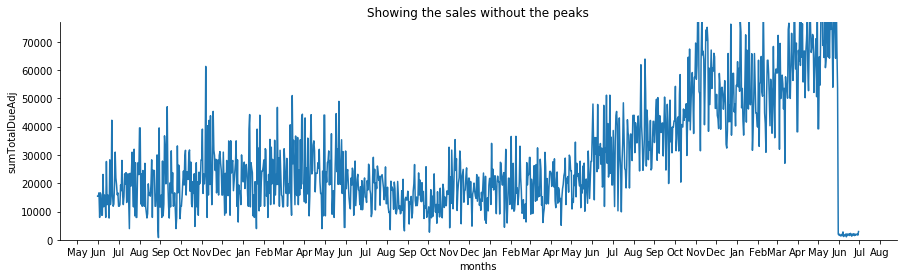

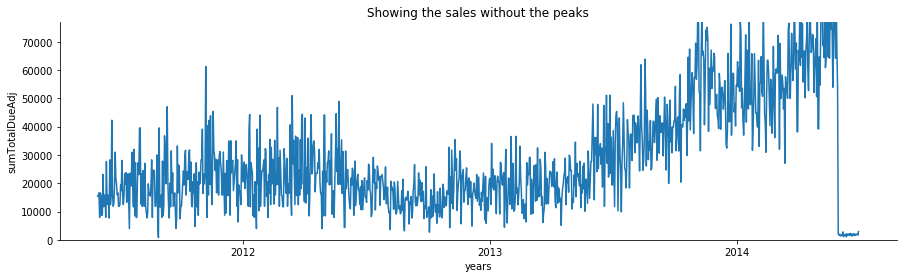

In [15]:
# Plot again

# This plot generates monthly xticks
fplot.plot_timeseries(x_values = monetary_sales['OrderDate'], 
                y_values = monetary_sales['sumTotalDueAdj'], 
                x_formatting = 'months',
                ylim = (-1, perc_95),
                y_label = "sumTotalDueAdj",
                title = "Showing the sales without the peaks")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = monetary_sales['OrderDate'], 
                y_values = monetary_sales['sumTotalDueAdj'], 
                x_formatting = 'years',
                ylim = (-1, perc_95),
                y_label = "sumTotalDueAdj",
                title = "Showing the sales without the peaks")

### 2. The spikes are always around the end of the month. Let's see if we find a similar pattern for the discounts. 

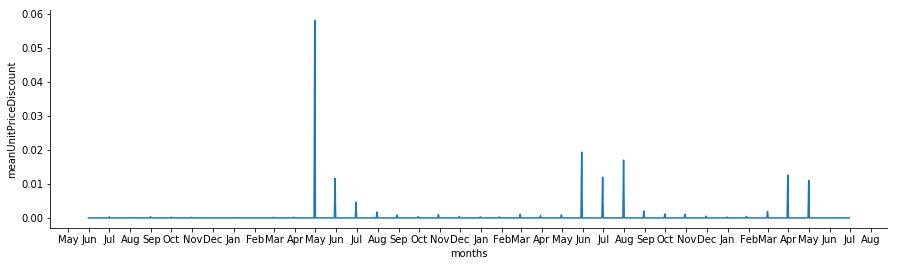

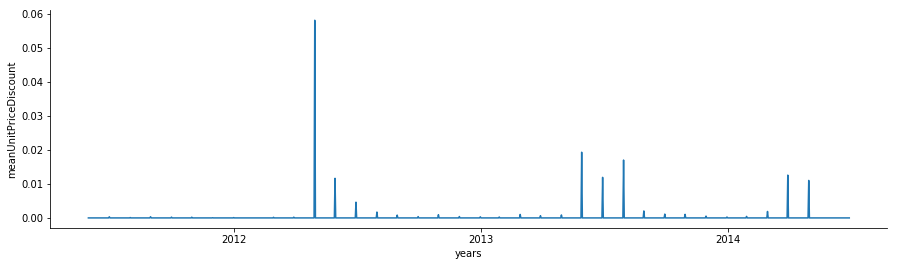

In [16]:
# Generate plots for the spikes
discounts = SO[["OrderDate", "UnitPriceDiscount"]].groupby("OrderDate").mean().reset_index()
discounts = discounts.rename(columns = {'UnitPriceDiscount' : 'meanUnitPriceDiscount'})
discounts = discounts.sort_values(by = "OrderDate")

fplot.plot_timeseries(x_values = discounts['OrderDate'], 
                y_values = discounts['meanUnitPriceDiscount'], 
                x_formatting = 'months',
               y_label = "meanUnitPriceDiscount")
fplot.plot_timeseries(x_values = discounts['OrderDate'], 
                y_values = discounts['meanUnitPriceDiscount'], 
                x_formatting = 'years',
               y_label = "meanUnitPriceDiscount")

This seems not to be the case. However, one can see that the big spike at the end of April 2012 causes the entire graph to flatten out. Maybe, if we change the y-limit values, we can get the other discounts to pop more. 

Another interesting observation is the huge discount spike at the end of April 2012. However, even though there was a huge discount. The monetary sales (see previous part) were not that high at the end of this month. 

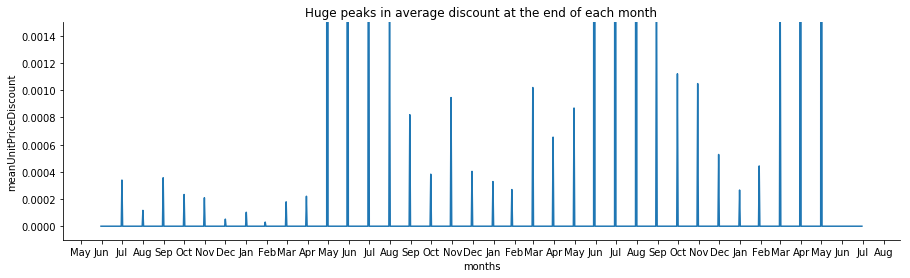

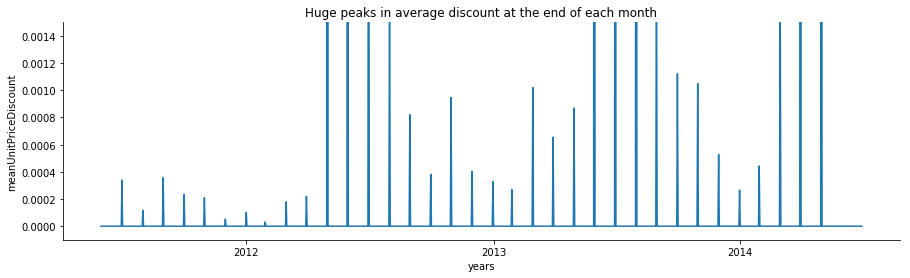

In [17]:
# Generate plots for the spikes, limiting the y-axis
fplot.plot_timeseries(x_values = discounts['OrderDate'], y_values = discounts['meanUnitPriceDiscount'], x_formatting = 'months', ylim = (-0.0001, 0.0015), y_label = "meanUnitPriceDiscount", title = "Huge peaks in average discount at the end of each month")
fplot.plot_timeseries(x_values = discounts['OrderDate'], y_values = discounts['meanUnitPriceDiscount'], x_formatting = 'years', ylim = (-0.0001, 0.0015), y_label = "meanUnitPriceDiscount", title = "Huge peaks in average discount at the end of each month")

Indeed, we can see the discounts come up. However, note that the company stopped discounting after May 2014. This is also when their sales dropped quite substantially. 

To end our basic analysis about the discounts, let's count the amount of days we had a certain discount, to see how many times there was no discount and which discounts were used most frequently. 

In [18]:
# Counting the occurrences of every discount (not average here, so we take SO instead of the discounts dataframe)
discount_counts = SO['UnitPriceDiscount'].value_counts().reset_index()
discount_counts.columns = ['UnitPriceDiscount', 'Count']
discount_counts

,UnitPriceDiscount,Count
0,0.00,128581
1,0.02,1310
2,0.05,606
3,0.15,590
4,0.20,231
5,0.10,178
6,0.40,169
7,0.35,137
8,0.30,61


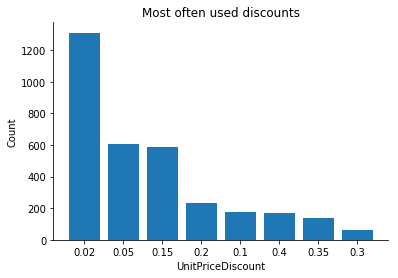

In [19]:
# since a discount of 0 is used very frequently, let's make a barplot without it.
fig, ax = plt.subplots()  
plt.bar(discount_counts["UnitPriceDiscount"].astype(str)[1:], discount_counts["Count"][1:])
plt.xlabel("UnitPriceDiscount")
plt.ylabel("Count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Most often used discounts")
plt.show()

We can see that a discount of 2% is most frequently used, followed by 5% and 15%.

### 3. How do the order quantities evolve over time?

(This is probably very similar to the monetary sales over time)

In [20]:
# Group the order quantities by day
order_quantities = SO[["OrderDate", "OrderQty"]].groupby("OrderDate").sum().reset_index()
order_quantities = order_quantities.rename(columns = {'OrderQty' : 'sumOrderQty'})
order_quantities = order_quantities.sort_values(by = "OrderDate")

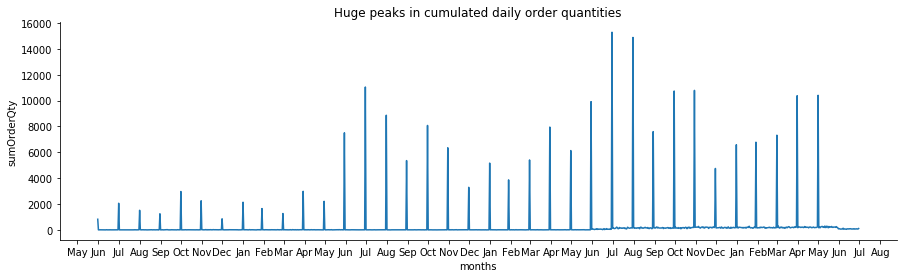

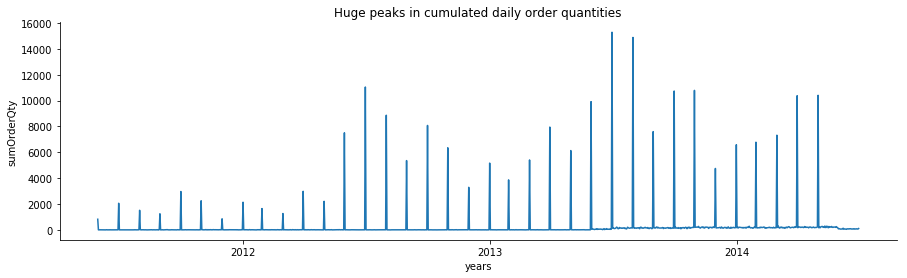

In [21]:
# plot the daily order quantities over time.

# This plot generates monthly xticks
fplot.plot_timeseries(x_values = order_quantities['OrderDate'], 
                y_values = order_quantities['sumOrderQty'], 
                x_formatting = 'months',
                y_label = "sumOrderQty",
                title = "Huge peaks in cumulated daily order quantities")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = order_quantities['OrderDate'], 
                y_values = order_quantities['sumOrderQty'], 
                x_formatting = 'years',
                y_label = "sumOrderQty",
                title = "Huge peaks in cumulated daily order quantities")

As expected, we can see the order quantities spike at the end of each month. To show this relation from a more statistical point of view, we will also look at the correlation between the monetary sales, order quantities and the discounts. But first, let's zoom in once again on the graph, while ignoring the spikes. 

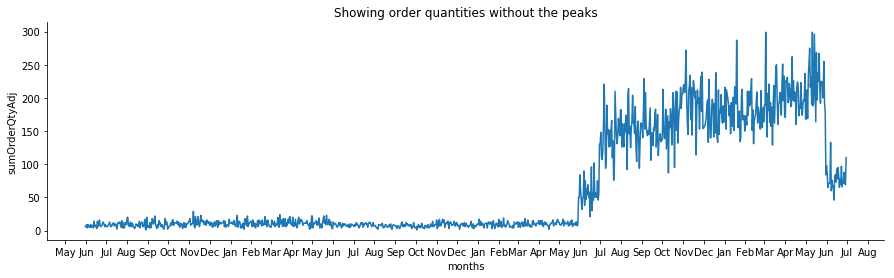

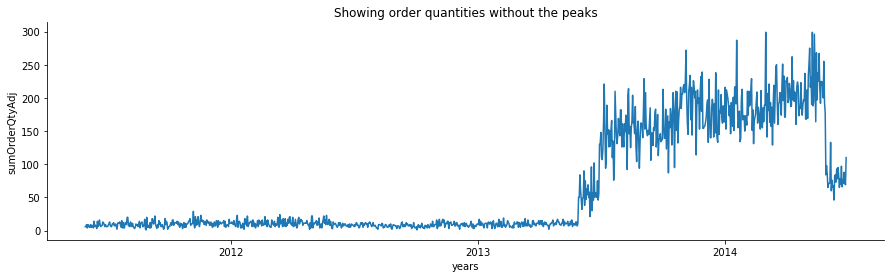

In [22]:
# get the spikes
spikes_orderQuantity = order_quantities.sort_values(by = "sumOrderQty", ascending = False).head(36)

# Make the spikes NaN
order_quantities["sumOrderQtyAdj"] = order_quantities["sumOrderQty"].apply(lambda x: np.nan if x in set(spikes_orderQuantity['sumOrderQty']) else x)

# Fill NaN values with previous value
order_quantities = order_quantities.fillna(method='backfill')

# Plot again

# This plot generates monthly xticks
fplot.plot_timeseries(x_values = order_quantities['OrderDate'], 
                y_values = order_quantities['sumOrderQtyAdj'], 
                x_formatting = 'months',
                y_label = "sumOrderQtyAdj",
                title = "Showing order quantities without the peaks")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = order_quantities['OrderDate'], 
                y_values = order_quantities['sumOrderQtyAdj'], 
                x_formatting = 'years',
                y_label = "sumOrderQtyAdj",
                title = "Showing order quantities without the peaks")

The 'baseline' number of products ordered per Sales Order seems to be quite stable until May - June 2013. After this period, there is an increase in number of products ordered per Sales Order. However, aroung the same period one year later, the number of products ordered per Sales Order drops again. 

In [23]:
# Check the correlation
np.corrcoef([order_quantities["sumOrderQty"], monetary_sales["sumTotalDue"], discounts['meanUnitPriceDiscount']])

array([[1.        , 0.97018758, 0.42206644],
       [0.97018758, 1.        , 0.39157405],
       [0.42206644, 0.39157405, 1.        ]])

We can see that there is a high correlation between the order quantity and the monetary sales. However, the correlation of these two variables respectively to the mean unit discount is substantially lower. As noted before - eg at the end of April 2012 - larger discounts do not always lead to larger sales (when compared to other discount periods). 

In [24]:
# Since the monetary value is never 0, we expect this to be the same for the order quantities. 
order_quantities[order_quantities['sumOrderQty'] ==  0].shape[0]

0

In [25]:
# Alternatively, we could check it by using the monetary_sales dataframe we created earlier
# If there are many days without sales, then we should find many occurrences where sumTotalDue = 0 in the following dataframe:
sumOrderQty_counts = order_quantities['sumOrderQty'].value_counts().reset_index()
sumOrderQty_counts.columns = ['sumOrderQty', 'occurrence']
sumOrderQty_counts= sumOrderQty_counts.sort_values(by = 'sumOrderQty', ascending = True)
sumOrderQty_counts.head()

,sumOrderQty,occurrence
104,1,2
15,2,9
13,3,16
8,4,34
7,5,41


As expected, there are no days without sales in terms of order quantity. 

Finally, we want to know how the order quantities in general (so not summed by day) are distributed

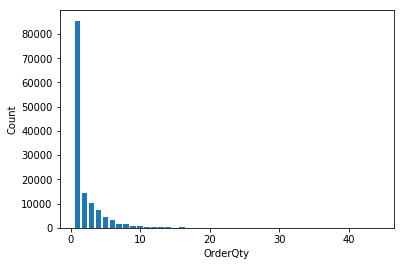

In [26]:
OrderQty_counts = SO['OrderQty'].value_counts().reset_index()
OrderQty_counts.columns = ["OrderQty", "count"]
plt.bar(OrderQty_counts["OrderQty"], OrderQty_counts["count"])
plt.xlabel("OrderQty")
plt.ylabel("Count")
plt.show()

Generally speaking, an order contains less than 10 units of a certain item (per item in that order). 

### 4. Are there long tail products? 

In [27]:
# To know whether there are long tail products, we must first count for each product how many times it was sold
per_product_quantity = SO[["ProductID", "OrderQty"]].groupby("ProductID").sum().reset_index().sort_values(by = "OrderQty")
per_product_quantity.columns = ["ProductID", "sumOrderQty"]
per_product_quantity = per_product_quantity.sort_values(by = "sumOrderQty", ascending = False)

per_product_quantity = per_product_quantity.merge(SO[["ProductID", "ProductName"]], how = "left", on = "ProductID")

# count how many times a product gets sold 1 time, 2 times, 3 times, ... 
count_of_counts = per_product_quantity["sumOrderQty"].value_counts().reset_index()
count_of_counts.columns = ["sumOrderQty", "occurrence"]
count_of_counts = count_of_counts.sort_values(by = "sumOrderQty")

count_of_counts.head()

,sumOrderQty,occurrence
246,4,2
245,7,5
243,8,6
244,10,6
239,15,18


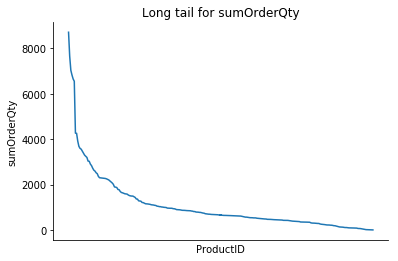

In [28]:
fplot.plot_longtail(per_product_quantity, "ProductID", "sumOrderQty")

We can clearly see that there are some products that are being sold a lot while others tend to be sold way less. 

Next, we look at the correlation between the number of products sold and the average discount per product

### 5. Are the total number of units sold for the products positively correlated with their average discounts?

In [29]:
# Sort number of products sold
per_product_quantity = per_product_quantity.sort_values(by = "ProductID")

# Check average discount per product
avg_disc_per_product = SO[["ProductID", "UnitPriceDiscount"]].groupby("ProductID").mean().reset_index()
avg_disc_per_product = avg_disc_per_product.rename(columns = {"UnitPriceDiscount" : "meanUnitPriceDiscount"})
avg_disc_per_product = avg_disc_per_product.sort_values(by = "ProductID")

# merge 
quantity_discount = per_product_quantity.merge(avg_disc_per_product, on = "ProductID")

# calculate correlation between the two 
np.corrcoef(quantity_discount["sumOrderQty"], quantity_discount["meanUnitPriceDiscount"])

array([[ 1.        , -0.12174528],
       [-0.12174528,  1.        ]])

This is rather strange, one would expect this to be positive!

In [30]:
# Visually: products that are selling well
quantity_discount.sort_values(by = "sumOrderQty", ascending = False).head(10)

,ProductID,sumOrderQty,ProductName,meanUnitPriceDiscount
12604,712,8709,AWC Logo Cap,0.000952
12805,712,8709,AWC Logo Cap,0.000952
12793,712,8709,AWC Logo Cap,0.000952
12794,712,8709,AWC Logo Cap,0.000952
12795,712,8709,AWC Logo Cap,0.000952
12796,712,8709,AWC Logo Cap,0.000952
12797,712,8709,AWC Logo Cap,0.000952
12798,712,8709,AWC Logo Cap,0.000952
12799,712,8709,AWC Logo Cap,0.000952
12800,712,8709,AWC Logo Cap,0.000952


In [31]:
# Visually: products with high discounts
quantity_discount.sort_values(by = "meanUnitPriceDiscount", ascending = False).head(10)

,ProductID,sumOrderQty,ProductName,meanUnitPriceDiscount
127467,985,467,"Mountain-500 Silver, 42",0.063519
127333,985,467,"Mountain-500 Silver, 42",0.063519
127345,985,467,"Mountain-500 Silver, 42",0.063519
127344,985,467,"Mountain-500 Silver, 42",0.063519
127343,985,467,"Mountain-500 Silver, 42",0.063519
127342,985,467,"Mountain-500 Silver, 42",0.063519
127341,985,467,"Mountain-500 Silver, 42",0.063519
127340,985,467,"Mountain-500 Silver, 42",0.063519
127339,985,467,"Mountain-500 Silver, 42",0.063519
127338,985,467,"Mountain-500 Silver, 42",0.063519


From this data, some products are sold on a regular basis (small  products), while other products are sold way less often (larger items), but get sold more in the discount periods. Therefore, the products which already have good sales volumes don't need to be discounted that heavily, resulting in a high volume, low discount combination. This partly explains the slightly negative correlation. On the other hand, products with low sales volumes get discounted more heavily. However, the fact that their sales volume still remains lower than the volume of the 'popular' products explains the negative correlation we found earlier as well. 

### 6. How does the average line total (total bill) evolve over time? 
###### In other words: do people tend to buy more or less during a visit?

In [32]:
# Get the LineTotal means
LT_means = SO[["OrderDate", "LineTotal"]].groupby("OrderDate").mean().reset_index().sort_values(by = "OrderDate")
LT_means = LT_means.rename(columns = {"LineTotal" : "meanLineTotal"})

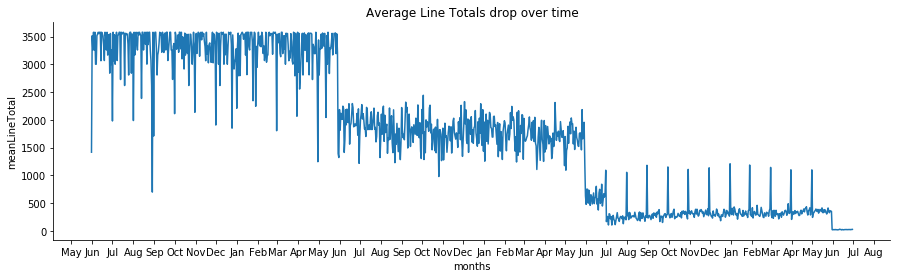

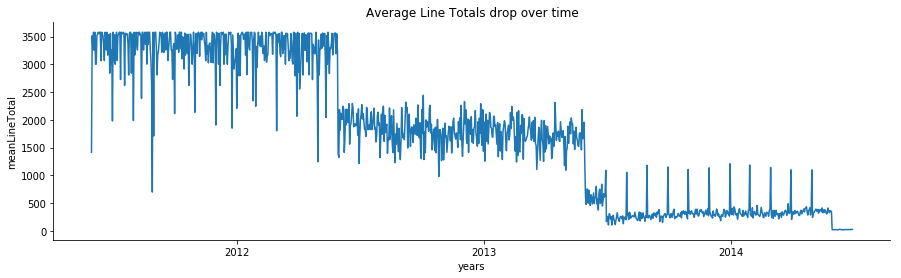

In [113]:
# plot the LineTotal means over time.

# This plot generates monthly xticks
fplot.plot_timeseries(x_values = LT_means['OrderDate'], 
                y_values = LT_means['meanLineTotal'], 
                x_formatting = 'months',
                y_label = "meanLineTotal",
                title = "Average Line Totals drop over time")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = LT_means['OrderDate'], 
                y_values = LT_means['meanLineTotal'], 
                x_formatting = 'years',
                y_label = "meanLineTotal",
                title = "Average Line Totals drop over time")

So, something interesting is going on here. While the first part of our analysis ("1. How do the monetary sales evolve over time?") indicated that the monetary sales were increasing between 2013 and 2014, we can see now that the meanLineTotal was actually decreasing over time. When people are buying less (in monetary terms) on each Sales Order, yet the total monetary sales are increasing, it can only be possible that the number of Sales Orders were increasing as well, thereby compensating the behaviour of people buying less on a Sales Order. The fact that the number of daily order quantities did indeed increase  in the year of 2013 was already shown in "3. How do the order quantities evolve over time?". 

However, interesting to know is why this change in behaviour took place. Looking at the graph above, there was a huge drop in number of products bought per sales order in May 2012. Furthermore, there was an additional drop in May 2013. Finally, this number seems to drop once again around May - June in 2014. But why? 

Maybe we can find the answer in the number of online orders. 

### 7. How do the number and share of online orders evolve over time? 

In [34]:
online_counts = SO[["OrderDate", "OnlineOrderFlag"]].groupby("OrderDate").sum().reset_index().sort_values(by = "OrderDate")
online_counts.columns = ["OrderDate", "nOnlineOrders"]

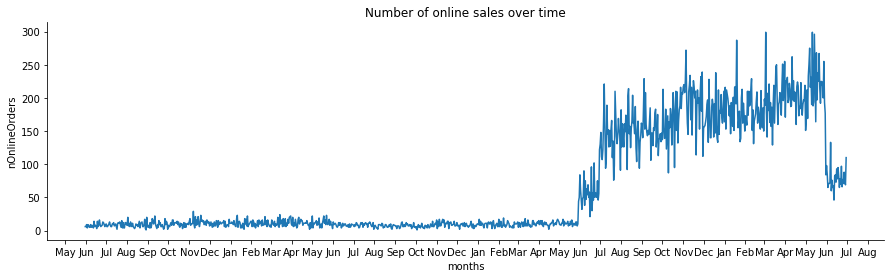

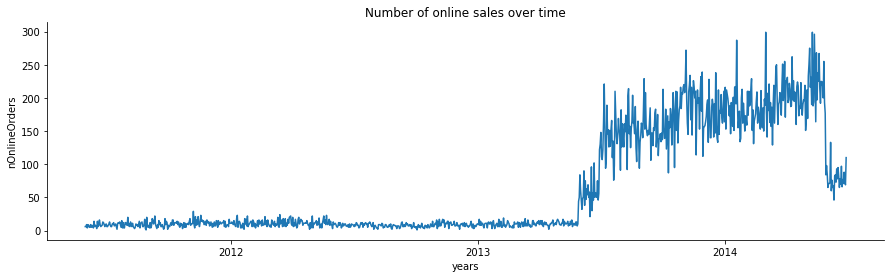

In [35]:
# This plot generates monthly xticks
fplot.plot_timeseries(x_values = online_counts['OrderDate'], 
                y_values = online_counts['nOnlineOrders'], 
                x_formatting = 'months',
               y_label = "nOnlineOrders",
                     title = "Number of online sales over time")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = online_counts['OrderDate'], 
                y_values = online_counts['nOnlineOrders'], 
                x_formatting = 'years',
               y_label = "nOnlineOrders",
                title = "Number of online sales over time")

As one could guess, the drop in number of units per Sales Order, paired with the rise of the number of sales orders is linked to the rise of the number of sales orders that were generated online. It is safe to guess that a webshop was created/ promoted/ improved around May 2013. Therefore, the number of online sales received a great boost which is translated in the overall sales quantity as well. Intuitively, (of course depending on which products the company sells as well) one could say that it's easier to buy less products when shopping online than when physically going to the stores. Therefore, the drop in avg line total is also intuitively explained. 

However, there is also a drop in online sales around May 2014. Probably, there is a problem with the website? Or a competitor is stealing some of our customers? It's important to find out why the online sales are declining. 

### 8. Similarly, one could be concerned about the "offline" sales as well

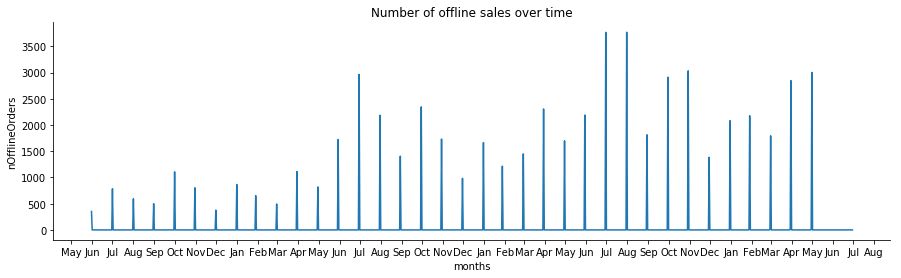

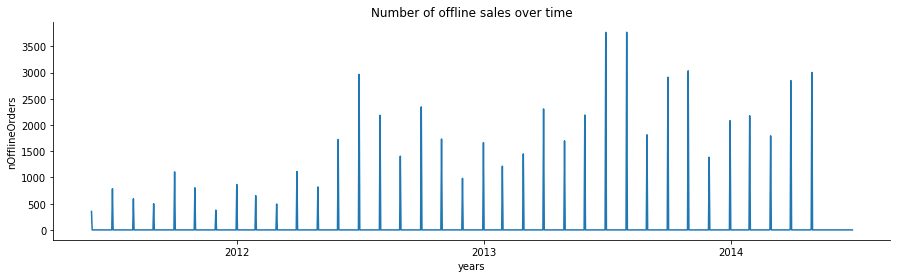

In [36]:
# Flip the boolean for offline
SO["OfflineOrderFlag"] = SO["OnlineOrderFlag"].apply(lambda x: False if x == True else True)

# Get the counts
online_counts = SO[["OrderDate", "OfflineOrderFlag"]].groupby("OrderDate").sum().reset_index().sort_values(by = "OrderDate")
online_counts.columns = ["OrderDate", "nOfflineOrders"]

# This plot generates monthly xticks
fplot.plot_timeseries(x_values = online_counts['OrderDate'], 
                y_values = online_counts['nOfflineOrders'], 
                x_formatting = 'months',
                y_label = "nOfflineOrders",
                title = "Number of offline sales over time")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = online_counts['OrderDate'], 
                y_values = online_counts['nOfflineOrders'], 
                x_formatting = 'years',
                y_label = "nOfflineOrders",
                title = "Number of offline sales over time")

Interestingly, the spikes are only happening for the offline sales. So, probably the discounts are mainly for when you go to the shop itself since we didn't see this 'spiky' plot when looking at the online sales. 

### 9. Who are the top customers?

In [37]:
# Using "LineTotal" from SalesOrderDetail is similar to taking "SubTotal" from SalesOrderHeader
# The reason why "TotalDue" was not used is because this contains freight costs (and tax) which is actually not really a part of the sales
# I.e the sales could be higher for a certain customer due to the difference in freight costs, rather than the difference in sales
# Therefore, the "TotalDue" was not used for this matter
LineTot_OrderQty_per_cust = SO[["CustomerID", "LineTotal", "OrderQty"]].groupby("CustomerID").sum().reset_index().rename(columns = {"LineTotal": "sumLineTotal", "OrderQty" : "sumOrderQty"})
SO_ext = pd.merge(
    SO, Sales_customer[["CustomerID", "PersonID"]], how = "left", on = "CustomerID").merge(  # get the PersonID
    Person_BusinessEntityContact[["PersonID", "BusinessEntityID"]], how = "left", on = "PersonID").merge( # get the BusinessEntityID
    Person_person[["BusinessEntityID", "FirstName", "LastName"]], how = "left", on = "BusinessEntityID")  # get the FirstName and LastName

In [38]:
print("Number of missing PersonIDs: ", sum(np.isnan(SO_ext["PersonID"])))
print("Number of non-missing PersonIDs: " ,len(SO_ext["PersonID"]) - sum(np.isnan(SO_ext["PersonID"])))

Number of missing PersonIDs:  0
Number of non-missing PersonIDs:  131863


In [39]:
print("Number of missing businessEntityIDs: ", sum(np.isnan(SO_ext["BusinessEntityID"])))
print("Number of non-missing businessEntityIDs: " ,len(SO_ext["BusinessEntityID"]) - sum(np.isnan(SO_ext["BusinessEntityID"])))

Number of missing businessEntityIDs:  70944
Number of non-missing businessEntityIDs:  60919


Apparently, we cannot find 50% of the names of the PersonIDs

In [40]:
SO.OnlineOrderFlag.value_counts(dropna = False)

True     70944
False    60919
Name: OnlineOrderFlag, dtype: int64

But these 60398 sales were online sales. In other words, the PersonID does not track the people who bought online. 

###### 9.1 In terms of monetary value

In [41]:
LineTot_OrderQty_per_cust = LineTot_OrderQty_per_cust.sort_values(by = "sumLineTotal", ascending = False)

# # get first and last name 
# LineTot_OrderQty_per_cut = LineTot_OrderQty_per_cut.merge(SO_ext[["CustomerID", "FirstName", "LastName"]], how = "left", on = "CustomerID")

In [42]:
LineTot_OrderQty_per_cust.shape

(19119, 3)

In [43]:
LineTot_OrderQty_per_cust.head(10)

,CustomerID,sumLineTotal,sumOrderQty
18818,29818,877107.192221,1558
18715,29715,853849.179524,1322
18722,29722,841908.770707,2737
19117,30117,816755.576276,1736
18614,29614,799277.895062,1931
18639,29639,787773.043768,1708
18701,29701,746317.529257,1688
18617,29617,740985.833742,1344
18994,29994,730798.713914,1408
18646,29646,727272.649367,1344


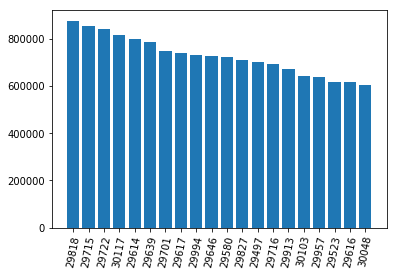

In [44]:
plt.bar(LineTot_OrderQty_per_cust["CustomerID"].astype(str)[0:20], LineTot_OrderQty_per_cust["sumLineTotal"][0:20])
plt.xticks(rotation = 79)
plt.show()

In [45]:
# How many customers do we have?
len(LineTot_OrderQty_per_cust["CustomerID"]) * 0.1

1911.9

In [46]:
top_10_perc_cust_LineTot = set(LineTot_OrderQty_per_cust["CustomerID"][0:1900])

###### 9.1 In terms of number of units bought

In [47]:
LineTot_OrderQty_per_cust = LineTot_OrderQty_per_cust.sort_values(by = "sumOrderQty", ascending = False)

In [48]:
LineTot_OrderQty_per_cust.shape

(19119, 3)

In [49]:
LineTot_OrderQty_per_cust.head(10)

,CustomerID,sumLineTotal,sumOrderQty
18722,29722,841908.770707,2737
18957,29957,636226.469980,2554
19048,30048,602559.892568,2350
18712,29712,580222.328277,2313
19103,30103,643745.895824,2129
18966,29966,537528.095868,2076
18705,29705,482738.704942,1963
18992,29992,429050.872825,1951
18913,29913,671618.029459,1946
18614,29614,799277.895062,1931


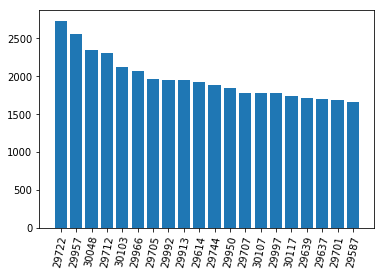

In [50]:
plt.bar(LineTot_OrderQty_per_cust["CustomerID"].astype(str)[0:20], LineTot_OrderQty_per_cust["sumOrderQty"][0:20])
plt.xticks(rotation = 79)
plt.show()

In [51]:
# Get the top 10% customers
top_10_perc_cust_OrderQty = set(LineTot_OrderQty_per_cust["CustomerID"][0:1900])

In [52]:
# Check the overlap
len(top_10_perc_cust_OrderQty.intersection(top_10_perc_cust_LineTot))

812

434 customers of the who are in the top customers in terms of number of products bought are not in the top customers in terms of monetary value! 

--> Some customers buy a lot of cheap products

### 10. Do we have "Long Tail" customers? Does the 80-20 rule hold? 

###### 10.1 In terms of monetary value

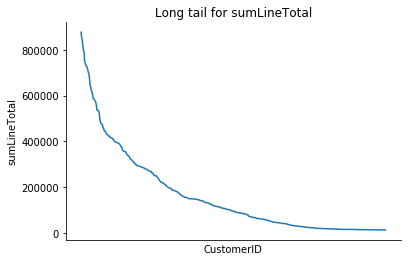

In [53]:
# Just plotting the first 500 customers for illustration purposes.
fplot.plot_longtail(LineTot_OrderQty_per_cust, "CustomerID", "sumLineTotal", limit = 500)

In [54]:
# Check 80-20 rule
twenty_perc = round(len(LineTot_OrderQty_per_cust["CustomerID"])*0.2)
np.sum(LineTot_OrderQty_per_cust["sumLineTotal"][0:twenty_perc]) / np.sum(LineTot_OrderQty_per_cust["sumLineTotal"])

0.7909580850484632

###### 10.2 In terms of total number of OrderQty

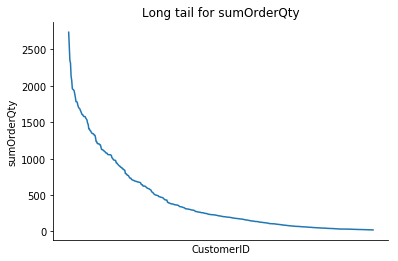

In [55]:
# Just plotting the first 500 customers for illustration purposes.
fplot.plot_longtail(LineTot_OrderQty_per_cust, "CustomerID", "sumOrderQty", limit = 500)

In [56]:
# Check 80-20 rule
twenty_perc = round(len(LineTot_OrderQty_per_cust["CustomerID"])*0.2)
np.sum(LineTot_OrderQty_per_cust["sumOrderQty"][0:twenty_perc]) / np.sum(LineTot_OrderQty_per_cust["sumOrderQty"])

0.8487704056610383

###### 10.3 How many people only order a product once or twice?

In [57]:
# For each CustomerID, count how many times it occurred with a sale
number_of_orders = SO["CustomerID"].value_counts().reset_index().rename(columns = {"CustomerID" : "count", "index" : "CustomerID"})
number_of_orders.head()

,CustomerID,count
0,29722,530
1,29966,482
2,29614,451
3,29950,446
4,30048,441


In [58]:
# How many people actually only have one order? 
print("Number of people with only 1 order: ", len(number_of_orders[number_of_orders["count"] == 1]))
print("Percentage of people with only 1 order: ", len(number_of_orders[number_of_orders["count"] == 1]) / len(number_of_orders["count"]))

print("Number of people with only 2 orders: ", len(number_of_orders[number_of_orders["count"] == 2]))
print("Percentage of people with only 2 orders: ", len(number_of_orders[number_of_orders["count"] == 2]) / len(number_of_orders["count"]))


Number of people with only 1 order:  2217
Percentage of people with only 1 order:  0.11595794759140123
Number of people with only 2 orders:  4876
Percentage of people with only 2 orders:  0.2550342591139704


In [59]:
order_percs = {"abs" : {}, "cum" : {}} 
for i in range(1, 11):
    order_percs["abs"][i] = len(number_of_orders[number_of_orders["count"] == i]) / len(number_of_orders["count"])
    order_percs["cum"][i] = len(number_of_orders[number_of_orders["count"] <= i]) / len(number_of_orders["count"])

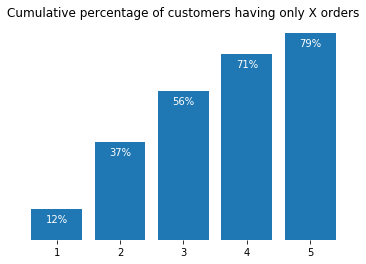

In [60]:
fig, ax = plt.subplots()  
ax.bar(list(order_percs["cum"].keys())[0:5], list(order_percs["cum"].values())[0:5])
for i, v in enumerate(list(order_percs["cum"].values())[0:5]):
    ax.text(i + 0.83, v - 0.05 , str(int(round(v * 100, 0))) + "%", color = "white")
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([])
plt.title("Cumulative percentage of customers having only X orders")
plt.show()

In other words, 40% of our customers are only making 2 orders which is really a high percentage. Therefore, it is very important to get people to buy more (i.e. prevent them from churning) 

In [61]:
# Check if the orders were mostly online
mostly_online = SO[["CustomerID","OnlineOrderFlag"]].groupby("CustomerID").mean()
number_of_orders = number_of_orders.merge(mostly_online, how = "left", on = "CustomerID")
number_of_orders["OfflineOrderFlag"] = number_of_orders["OnlineOrderFlag"].apply(lambda x: False if x == True else True)

In [62]:
# What does this dataframe look like? 
number_of_orders.head()

,CustomerID,count,OnlineOrderFlag,OfflineOrderFlag
0,29722,530,False,True
1,29966,482,False,True
2,29614,451,False,True
3,29950,446,False,True
4,30048,441,False,True


In [63]:
# Make a table
quantity_table = number_of_orders[["count", "OnlineOrderFlag", "OfflineOrderFlag"]].groupby("count").sum().reset_index()

In [64]:
quantity_table.head(10)

,count,OnlineOrderFlag,OfflineOrderFlag
0,1,2191.0,26.0
1,2,4858.0,18.0
2,3,3687.0,14.0
3,4,2713.0,10.0
4,5,1507.0,18.0
5,6,1244.0,14.0
6,7,533.0,15.0
7,8,599.0,11.0
8,9,457.0,9.0
9,10,249.0,11.0


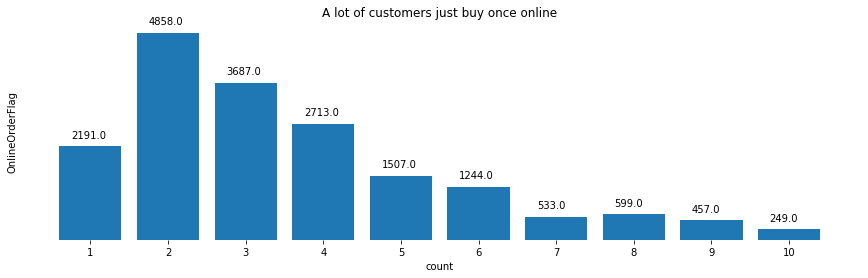

In [65]:
fplot.fancy_barplot(quantity_table, "count", "OnlineOrderFlag", 
              ascending = True, limit = 10, figsize = (15,4), title = "A lot of customers just buy once online", 
              shiftparams = [-0.25, 200], sort_x = True)

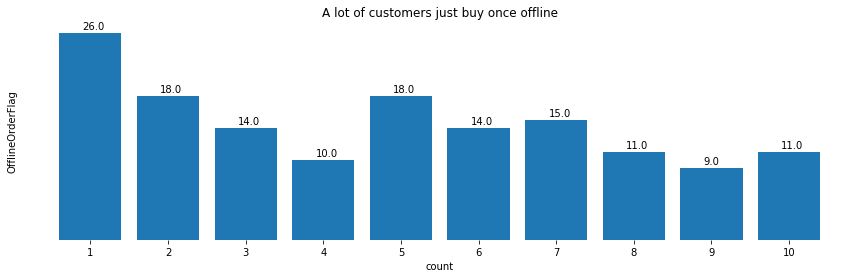

In [66]:
fplot.fancy_barplot(quantity_table, "count", "OfflineOrderFlag", 
              ascending = True, limit = 10, figsize = (15,4), title = "A lot of customers just buy once offline", 
              shiftparams = [-0.1, 0.5], sort_x = True)

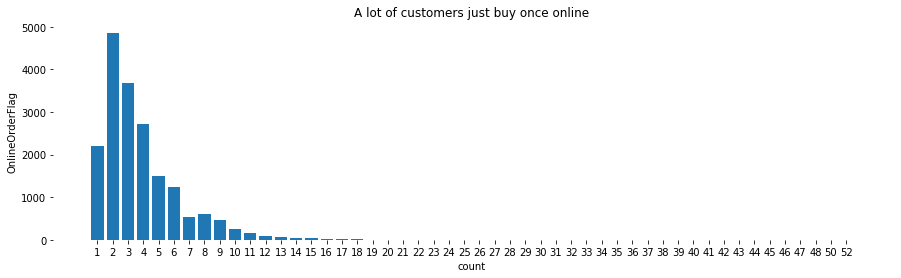

In [67]:
# plotting a bigger part of the distribution
fplot.fancy_barplot(quantity_table, "count", "OnlineOrderFlag", 
              ascending = True, limit = 50, figsize = (15,4), title = "A lot of customers just buy once online", 
              fancylabels = False, sort_x = True)

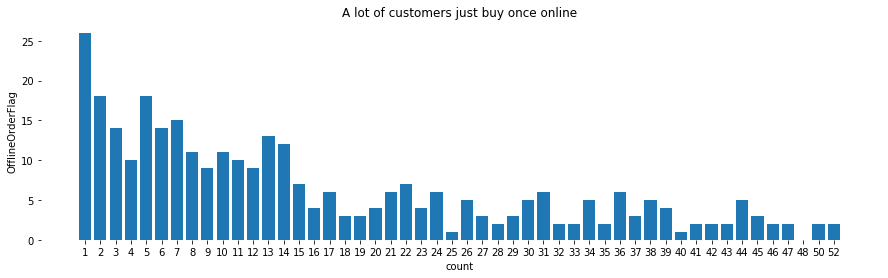

In [68]:
fplot.fancy_barplot(quantity_table, "count", "OfflineOrderFlag", 
              ascending = True, limit = 50, figsize = (15,4), title = "A lot of customers just buy once online", 
              fancylabels = False, sort_x = True)

### 11. Which sales person is involved in the most transactions? Also the highest LineTotal? 

###### 11.1 Number of transactions

In [69]:
# This number of NA values looks familiar. Probably, they are due to online sales
SO.OnlineOrderFlag.value_counts(dropna = False)

True     70944
False    60919
Name: OnlineOrderFlag, dtype: int64

Indeed, the number of missing SalesPersonIDs is identical to the number of online sales. Which makes completely sense! 

In [70]:
most_involved_transactions = SO.SalesPersonID.value_counts().reset_index()
most_involved_transactions.columns = ["SalesPersonID", "count"]
most_involved_transactions["SalesPersonID"] = most_involved_transactions["SalesPersonID"].astype(int)

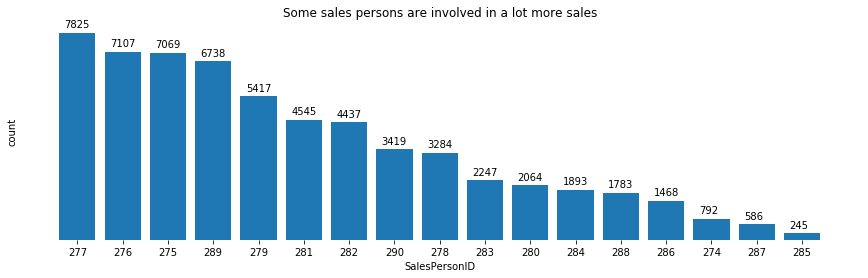

In [71]:
fplot.fancy_barplot(most_involved_transactions, "SalesPersonID", "count", 
              ascending = False, limit = None, figsize = (15,4), title = "Some sales persons are involved in a lot more sales", 
              shiftparams = [-0.28, 200])

###### 11.1 Linetotal

In [72]:
highest_line_totals = SO[["SalesPersonID", "LineTotal"]].groupby("SalesPersonID").sum().reset_index().rename(columns = {"LineTotal" : "sumLineTotal"})
highest_line_totals["SalesPersonID"] = highest_line_totals["SalesPersonID"].astype(int)

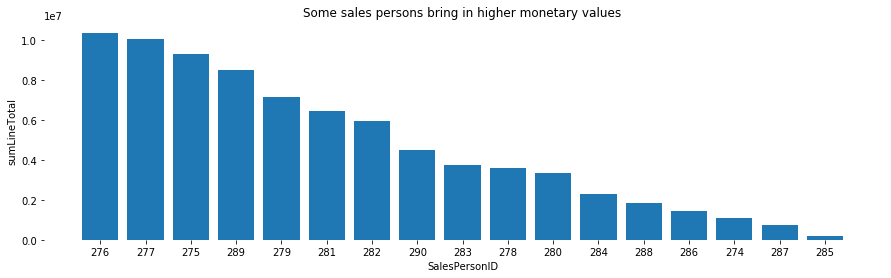

In [73]:
fplot.fancy_barplot(highest_line_totals, "SalesPersonID", "sumLineTotal", 
              ascending = False, limit = None, figsize = (15,4), title = "Some sales persons bring in higher monetary values", 
              shiftparams = [-0.28, 200], fancylabels = False)

### 12. But is this due to the fact that some sales people joined later? 

In order to sort this out, we check the average time between sales and the date of the first sale of each sales person

In [74]:
# Get the first sale of each salesperson
SalesPerson_first_date = SO[SO["SalesPersonID"] >0][["SalesPersonID", "OrderDate"]].sort_values(by = ["SalesPersonID", "OrderDate"])
SalesPerson_first_date["SalesPersonID"] = SalesPerson_first_date["SalesPersonID"].astype(int)
SalesPerson_first_date = SalesPerson_first_date.groupby("SalesPersonID").first().reset_index()

# get last registered sales date 
last_date = list(SO["OrderDate"])
last_date.sort()
last_date = last_date[-1]

# take time difference in days 
SalesPerson_first_date["diff"] = last_date - SalesPerson_first_date["OrderDate"]
SalesPerson_first_date["diff"] = pd.to_numeric(SalesPerson_first_date["diff"].dt.days, downcast='integer')

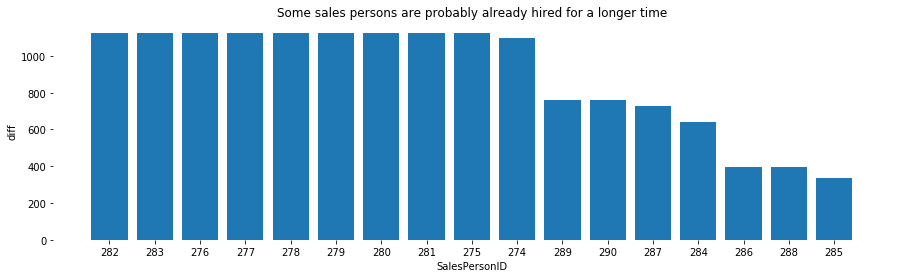

In [75]:
fplot.fancy_barplot(SalesPerson_first_date, "SalesPersonID", "diff", 
              ascending = False, limit = None, figsize = (15,4), title = "Some sales persons are probably already hired for a longer time", 
              shiftparams = [-0.28, 200], fancylabels = False)

In [76]:
# lagg the date by 1 
SalesPerson_date = SO[SO["SalesPersonID"] > 0][["SalesPersonID", "OrderDate"]].sort_values(by = ["SalesPersonID", "OrderDate"])
SalesPerson_date["SalesPersonID"] = SalesPerson_date["SalesPersonID"].astype(int)
SalesPerson_date["OrderDatePrev"] = SalesPerson_date.groupby("SalesPersonID").shift(1)

# To check the code
# SalesPerson_date[pd.isnull(SalesPerson_date["OrderDatePrev"])]

# get time differences
SalesPerson_date["timediff_in_days"] = SalesPerson_date["OrderDate"] - SalesPerson_date["OrderDatePrev"]
SalesPerson_date["timediff_in_days"] = pd.to_numeric(SalesPerson_date["timediff_in_days"].dt.days, downcast = "integer")
# SalesPerson_date["diff"] = SalesPerson_date["OrderDate"] - SalesPerson_date["OrderDatePrev"]

# Get mean difference
mean_time_between_sales = SalesPerson_date[["SalesPersonID","timediff_in_days"]].groupby("SalesPersonID").mean().reset_index()
mean_time_between_sales = mean_time_between_sales.sort_values(by = "timediff_in_days", ascending = True)

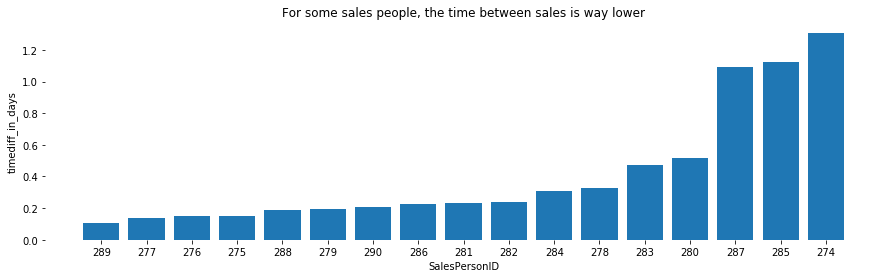

In [77]:
fplot.fancy_barplot(mean_time_between_sales, "SalesPersonID", "timediff_in_days", 
              ascending = True, limit = None, figsize = (15,4), title = "For some sales people, the time between sales is way lower", 
              shiftparams = [-0.28, 200], fancylabels = False)

### 13. Do the average sales and number of customers differ across territories? 

In [78]:
# Meanwhile, also count the number of customers in each territory 
across_territories = SO[["TerritoryName_ext", "LineTotal", "CustomerID", "OnlineOrderFlag", "OfflineOrderFlag"]].groupby("TerritoryName_ext").agg({"LineTotal" : ["mean"], "CustomerID" : ["count"], "OnlineOrderFlag" : "sum", "OfflineOrderFlag": ["sum"]}).reset_index()
across_territories["sumLineTotal"] = across_territories["LineTotal"]["mean"]
across_territories["countCustID"] = across_territories["CustomerID"]["count"]
across_territories["sumOnlineOrderFlag"] = across_territories["OnlineOrderFlag"]["sum"]
across_territories["sumOfflineOrderFlag"] = across_territories["OfflineOrderFlag"]["sum"]
across_territories["percOnlineOrder"] = round(across_territories["sumOnlineOrderFlag"] / (across_territories["sumOnlineOrderFlag"] + across_territories["sumOfflineOrderFlag"]) * 100, 0).astype(int)
across_territories = across_territories.drop(columns = ["LineTotal", "CustomerID", "OnlineOrderFlag", "OfflineOrderFlag"], axis = 1)
across_territories

D:\Anaconda\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,TerritoryName_ext,sumLineTotal,countCustID,sumOnlineOrderFlag,sumOfflineOrderFlag,percOnlineOrder
,,,,,,
0,AU_Australia,751.535409,17523,15810.0,1713.0,90
1,CA_Canada,847.761563,20118,8674.0,11444.0,43
2,DE_Germany,653.490990,8625,6722.0,1903.0,78
3,FR_France,784.476155,9977,6447.0,3530.0,65
4,GB_United Kingdom,724.801723,11707,8187.0,3520.0,70
5,US_Central,1354.632373,5839,27.0,5812.0,0
6,US_Northeast,1189.063482,5836,27.0,5809.0,0
7,US_Northwest,941.792557,18316,10444.0,7872.0,57
8,US_Southeast,1318.301409,5979,42.0,5937.0,1


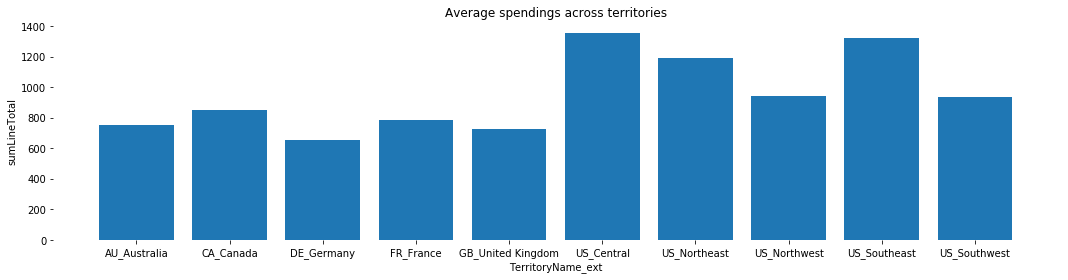

In [79]:
# Plot average spendings across territories
fplot.fancy_barplot(across_territories, "TerritoryName_ext", "sumLineTotal", 
              ascending = True, limit = None, figsize = (18,4), title = "Average spendings across territories", 
              shiftparams = [-0.28, 200], fancylabels = False, sort_x = True)

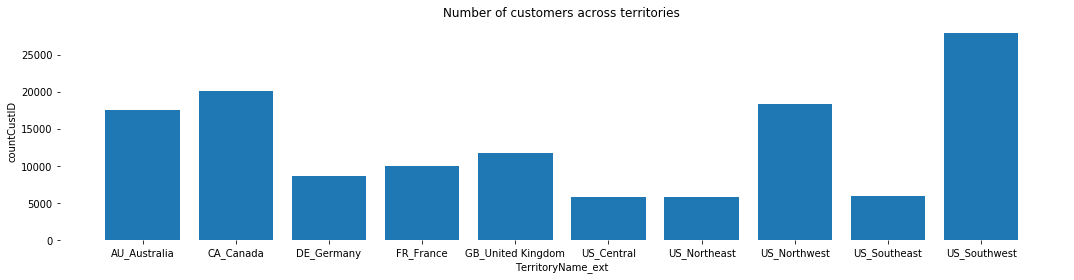

In [80]:
# Plot number of customers across territories
fplot.fancy_barplot(across_territories, "TerritoryName_ext", "countCustID", 
              ascending = True, limit = None, figsize = (18,4), title = "Number of customers across territories", 
              shiftparams = [-0.28, 200], fancylabels = False, sort_x = True)

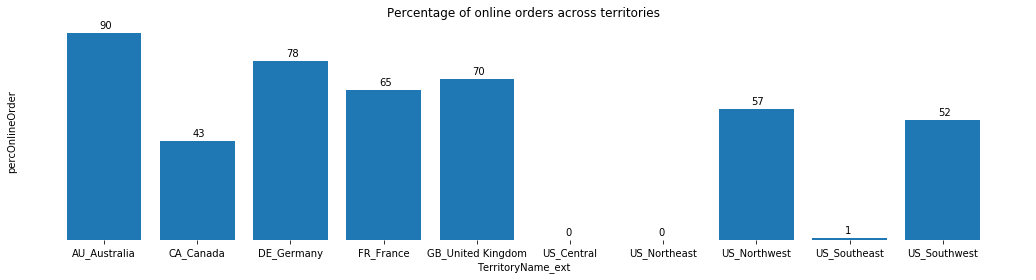

In [81]:
# Plot Percentage of online orders across territories
fplot.fancy_barplot(across_territories, "TerritoryName_ext", "percOnlineOrder", 
              ascending = True, limit = None, figsize = (18,4), title = "Percentage of online orders across territories", 
              shiftparams = [-0.05, 2], fancylabels = True, sort_x = True)

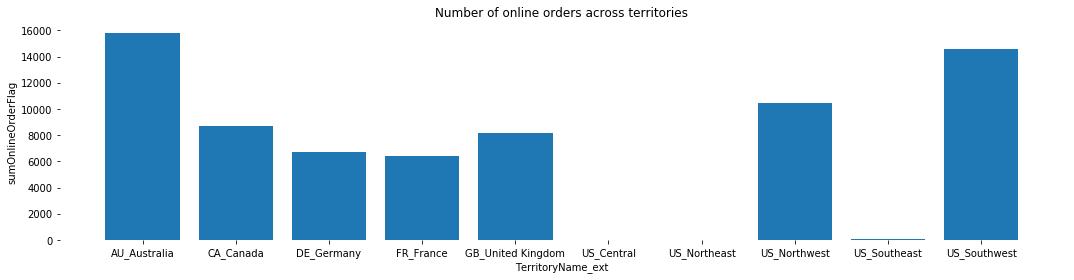

In [82]:
# Number of online orders separately plotted
fplot.fancy_barplot(across_territories, "TerritoryName_ext", "sumOnlineOrderFlag", 
              ascending = True, limit = None, figsize = (18,4), title = "Number of online orders across territories", 
              shiftparams = [-0.28, 200], fancylabels = False, sort_x = True)

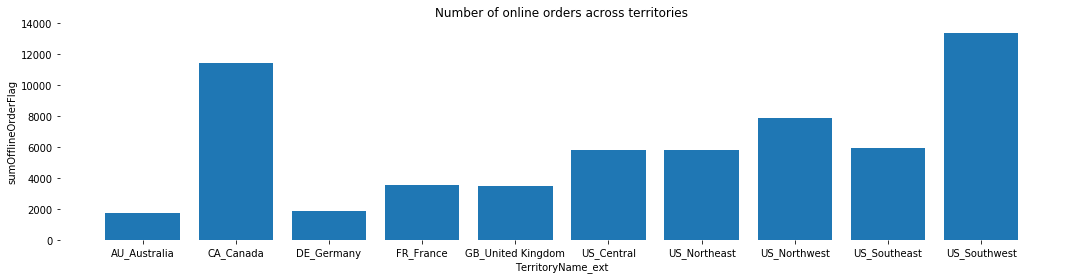

In [83]:
# Number of offline orders separately plotted
fplot.fancy_barplot(across_territories, "TerritoryName_ext", "sumOfflineOrderFlag", 
              ascending = True, limit = None, figsize = (18,4), title = "Number of online orders across territories", 
              shiftparams = [-0.28, 200], fancylabels = False, sort_x = True)

### 14. Does the shipping method change across territories? 

In [84]:
# Get the mode for the shipment method of each territory
ship_per_territory = SO[['TerritoryName_ext','ShipMethodID']].groupby("TerritoryName_ext").agg(lambda x:x.value_counts().index[0]).reset_index()

# Alternative way to get this 
ship_per_territory_alt = SO[['TerritoryName_ext','ShipMethodID']].groupby("TerritoryName_ext").agg(pd.Series.mode)

# Merge with info about the ship method 
ship_per_territory = ship_per_territory.merge(Purchasing_ShipMethod[["ShipMethodID", "Name"]], how = "left", on = "ShipMethodID")
ship_per_territory = ship_per_territory.rename(columns = {"Name" : "ShipmentName"})

In [85]:
ship_per_territory

,TerritoryName_ext,ShipMethodID,ShipmentName
0,AU_Australia,1,XRQ - TRUCK GROUND
1,CA_Canada,5,CARGO TRANSPORT 5
2,DE_Germany,1,XRQ - TRUCK GROUND
3,FR_France,1,XRQ - TRUCK GROUND
4,GB_United Kingdom,1,XRQ - TRUCK GROUND
5,US_Central,5,CARGO TRANSPORT 5
6,US_Northeast,5,CARGO TRANSPORT 5
7,US_Northwest,1,XRQ - TRUCK GROUND
8,US_Southeast,5,CARGO TRANSPORT 5
9,US_Southwest,1,XRQ - TRUCK GROUND


### 15. Does the shipping method differ for Online and Oflline orders? 

In [86]:
# Get the mode for the shipment method of each territory
ship_online_offline = SO[['OnlineOrderFlag','ShipMethodID']].groupby("OnlineOrderFlag").agg(lambda x:x.value_counts().index[0]).reset_index()


# Merge with info about the ship method 
ship_online_offline = ship_online_offline.merge(Purchasing_ShipMethod[["ShipMethodID", "Name"]], how = "left", on = "ShipMethodID")
ship_online_offline = ship_online_offline.rename(columns = {"Name" : "ShipmentName"})

In [87]:
ship_online_offline

,OnlineOrderFlag,ShipMethodID,ShipmentName
0,False,5,CARGO TRANSPORT 5
1,True,1,XRQ - TRUCK GROUND


In [88]:
# More detailed 
SO[SO["OnlineOrderFlag"] == 1]['ShipMethodID'].value_counts()

1    70944
Name: ShipMethodID, dtype: int64

In [89]:
# More detailed 
SO[SO["OnlineOrderFlag"] == 0]['ShipMethodID'].value_counts()

5    60919
Name: ShipMethodID, dtype: int64

In other words, all online orders are shipped with by XRQ - Truck Ground and all offline orders are shipped by Cargo Transport 5.

### 16. Does the shipping method change over time?

In [90]:
# get daily counts for truck
truck_daily =  SO[SO["ShipMethodID"] == 1]["OrderDate"].value_counts().reset_index()
truck_daily.columns = ["OrderDate", "truck_count"]

# get daily counts for cargo
cargo_daily = SO[SO["ShipMethodID"] == 5]["OrderDate"].value_counts().reset_index()
cargo_daily.columns = ["OrderDate", "cargo_count"]

# merge
daily_transport = truck_daily.merge(cargo_daily, how = "outer", on = "OrderDate")

In [91]:
# check NA values
daily_transport.isna().sum()

OrderDate         0
truck_count       0
cargo_count    1084
dtype: int64

In [92]:
# Fill all NA values with 0 (cause cargo did not occur on these dates) 
daily_transport = daily_transport.fillna(0)

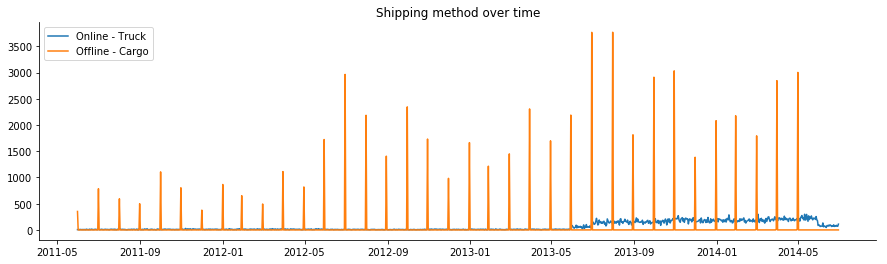

In [117]:
# Order by date and plot
daily_transport = daily_transport.sort_values(by = "OrderDate", ascending = True)

# setup plot
fig, ax = plt.subplots(figsize = (15,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot
plt.plot(daily_transport["OrderDate"], daily_transport["truck_count"], label = "Online - Truck")
plt.plot(daily_transport["OrderDate"], daily_transport["cargo_count"], label = "Offline - Cargo")

plt.legend(loc = "upper left")
plt.title("Shipping method over time")
plt.show()

As expected, this is just the same plot as in the beginning. 

In other words, the offline sales typically have high discounted peaks at the end of the month and are always shipped by cargo. The online sales have a more continuous pattern and are shipped by truck. 

As a final validation to this, we check if the online sales are also discounted often or not. 

### 17. Average discount for online and offline sales

In [94]:
SO[["OnlineOrderFlag", "UnitPriceDiscount"]].groupby("OnlineOrderFlag").mean().reset_index().rename(columns = {"UnitPriceDiscount" : "meanUnitPriceDiscount"})

,OnlineOrderFlag,meanUnitPriceDiscount
0,False,0.005628
1,True,0.000000


As expected, the online orders are never discounted. 

### 18. Credit Card usage: 

##### 18.1 Does the credit card usage differ over territories? 

In [95]:
# Get the percentage of credit card usage for every territory
CreditCard_per_territory = SO[["TerritoryName_ext", "CreditCardID", "CustomerID"]].groupby("TerritoryName_ext").agg({"CreditCardID": "count", "CustomerID" : "count"}).reset_index()
CreditCard_per_territory["perc_CreditCard"] = round(CreditCard_per_territory["CreditCardID"] / CreditCard_per_territory["CustomerID"] * 100).astype(int)

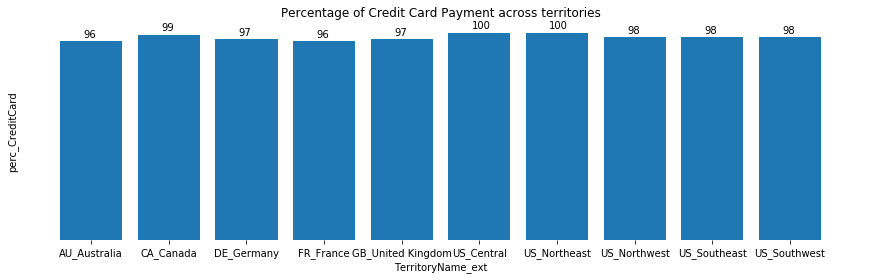

In [96]:
fplot.fancy_barplot(CreditCard_per_territory, "TerritoryName_ext", "perc_CreditCard", 
              ascending = True, limit = None, figsize = (15,4), title = "Percentage of Credit Card Payment across territories", 
              shiftparams = [-0.1, 2], fancylabels = True, sort_x = True)

Not really a difference. 

##### 18.2 And does it differ for Online and Offline sales? 

In [97]:
# Get the percentage of credit card usage for every territory
CreditCard_Online_offline = SO[["OnlineOrderFlag", "CreditCardID", "CustomerID"]].groupby("OnlineOrderFlag").agg({"CreditCardID": "count", "CustomerID" : "count"}).reset_index()
CreditCard_Online_offline["perc_CreditCard"] = round(CreditCard_Online_offline["CreditCardID"] / CreditCard_Online_offline["CustomerID"] * 100).astype(int)

In [98]:
CreditCard_Online_offline[["OnlineOrderFlag", "perc_CreditCard"]]

,OnlineOrderFlag,perc_CreditCard
0,False,100
1,True,96


### 19: Freight costs

###### 19.1 Do the freight costs differ over territories?

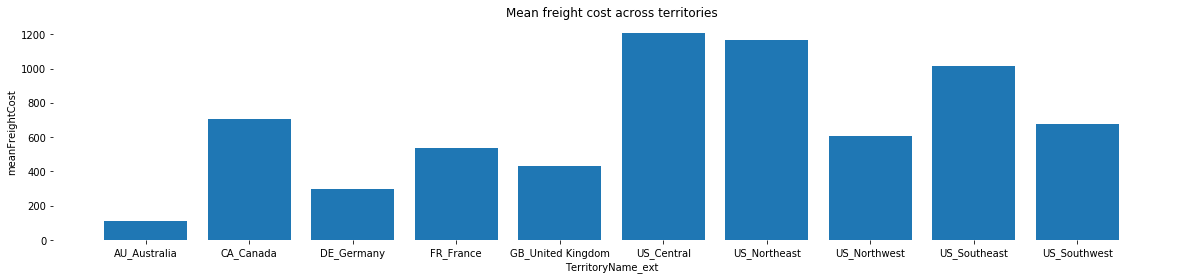

In [99]:
freight_per_territory = SO[["TerritoryName_ext", "Freight"]].groupby("TerritoryName_ext").mean().reset_index().rename(columns = {"Freight" : "meanFreightCost"})
fplot.fancy_barplot(freight_per_territory, "TerritoryName_ext", "meanFreightCost", 
              ascending = True, limit = None, figsize = (20,4), title = "Mean freight cost across territories", 
              shiftparams = [-0.1, 2], fancylabels = False, sort_x = True)

There is quite some difference in freight costs, but this might be due to distance and regulations. 

### 19.2 When was the first sale in each territory? 

In [100]:
# Find the dates for the first sales in every territory
first_order_per_territory = SO.loc[SO.groupby('TerritoryName_ext')['OrderDate'].idxmin()][["TerritoryName_ext", "OrderDate"]].sort_values(by = "OrderDate")
first_order_per_territory

,TerritoryName_ext,OrderDate
357,AU_Australia,2011-05-31
14,CA_Canada,2011-05-31
354,FR_France,2011-05-31
76,US_Central,2011-05-31
128,US_Northeast,2011-05-31
52,US_Northwest,2011-05-31
0,US_Southeast,2011-05-31
51,US_Southwest,2011-05-31
368,GB_United Kingdom,2011-06-02
375,DE_Germany,2011-06-03


### 19.3 do the average freight costs change over time?

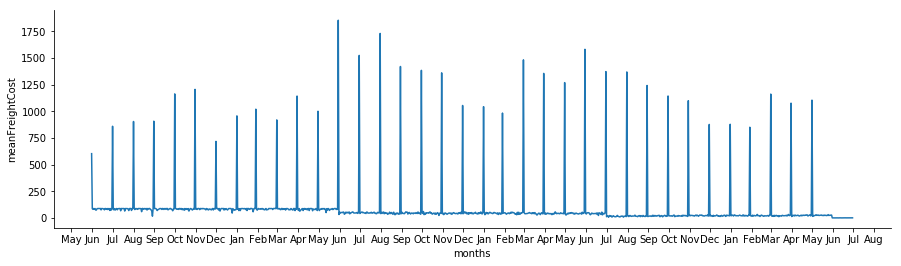

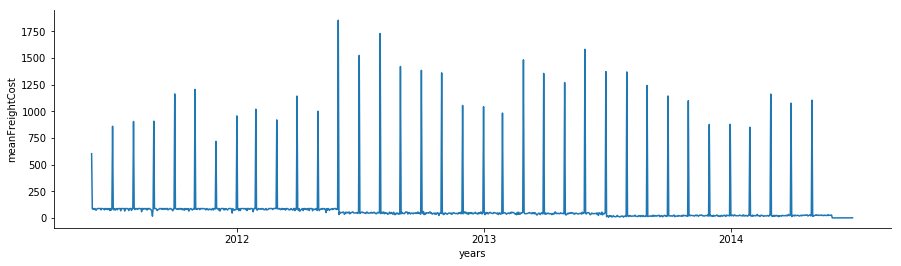

In [101]:
# Do we see the average freight costs go down when the first sales in the UK and Germany are registered? 
daily_freight = SO[["OrderDate", "Freight"]].groupby("OrderDate").mean().reset_index().rename(columns = {"Freight" : "meanFreightCost"}).sort_values(by = "OrderDate")
fplot.plot_timeseries(x_values = daily_freight['OrderDate'], 
                y_values = daily_freight['meanFreightCost'], 
                x_formatting = 'months',
               y_label = "meanFreightCost")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = daily_freight['OrderDate'], 
                y_values = daily_freight['meanFreightCost'], 
                x_formatting = 'years',
               y_label = "meanFreightCost")

We see huge spikes at the end of each month. This is not surprising, since at the end of each month, we also saw spikes in the discounts. In other words, at the end of the month, there is probably a discount for when you buy a big amount. Because of the fact that this big amout of products needs to be shipped, the shipping costs peak as well. 

Furthermore, we can see that the average shipping costs have been declining in June 2012 and in July 2013. This was probably as a response to the average line totals that were declining in these periods. Note that, around these two periods, the discount peaks at the end of each month were also peaking. 

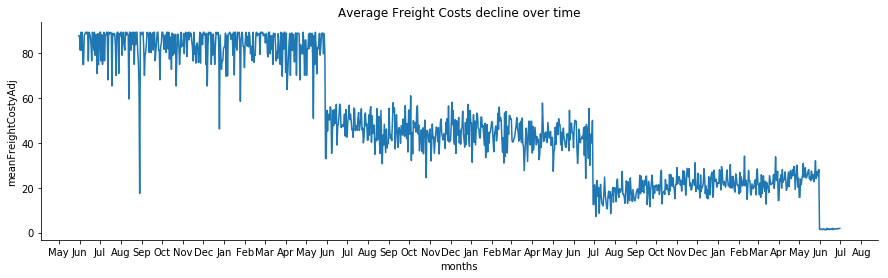

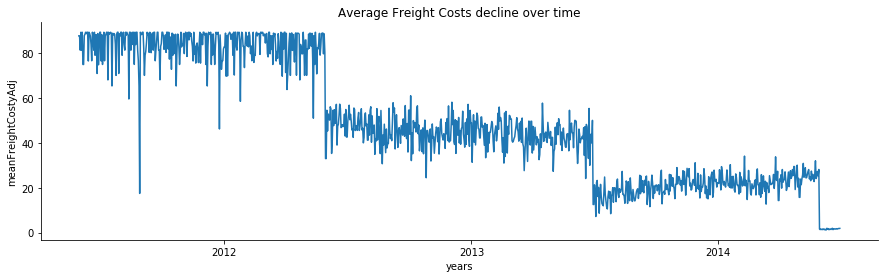

In [114]:
####################################
# plot the same without the spikes #
####################################

# get the spikes
spikes_freightCost = daily_freight.sort_values(by = "meanFreightCost", ascending = False).head(36)

# Make the spikes NaN
daily_freight["meanFreightCostAdj"] = daily_freight["meanFreightCost"].apply(lambda x: np.nan if x in set(spikes_freightCost['meanFreightCost']) else x)

# Fill NaN values with previous value
daily_freight = daily_freight.fillna(method='backfill')

# Plot again

# This plot generates monthly xticks
fplot.plot_timeseries(x_values = daily_freight['OrderDate'], 
                y_values = daily_freight['meanFreightCostAdj'], 
                x_formatting = 'months',
                y_label = "meanFreightCostyAdj",
                title = "Average Freight Costs decline over time")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = daily_freight['OrderDate'], 
                y_values = daily_freight['meanFreightCostAdj'], 
                x_formatting = 'years',
                y_label = "meanFreightCostyAdj",
                title = "Average Freight Costs decline over time")

### 20. Which territories have the most fluctuations in sales?

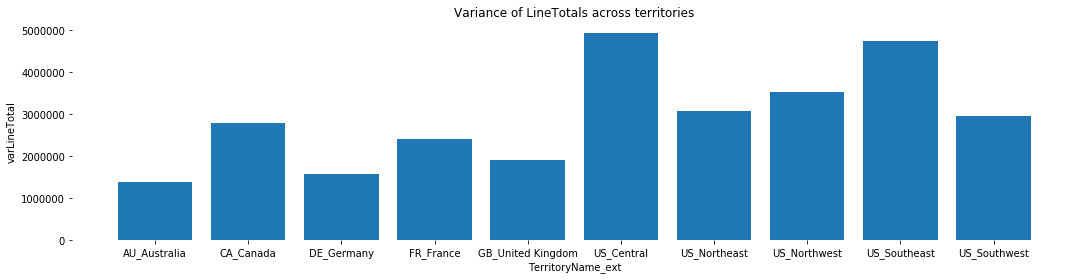

In [103]:
territory_fluc = SO[["TerritoryName_ext", "LineTotal"]].groupby("TerritoryName_ext").agg({"LineTotal" : "var"}).reset_index().rename(columns = {"LineTotal" : "varLineTotal"})
fplot.fancy_barplot(territory_fluc, "TerritoryName_ext", "varLineTotal", 
              ascending = True, limit = None, figsize = (18,4), title = "Variance of LineTotals across territories", 
              shiftparams = [-0.1, 2], fancylabels = False, sort_x = True)

it seems like (not statistically tested) there is a higher variance in the sales in the US than in other territories. This could be due to the fact that in the US, discounts occur more often, causing the sales to be higher. In order to check this, let's look at the average discount per territory. 

### 21. Average discount per territory

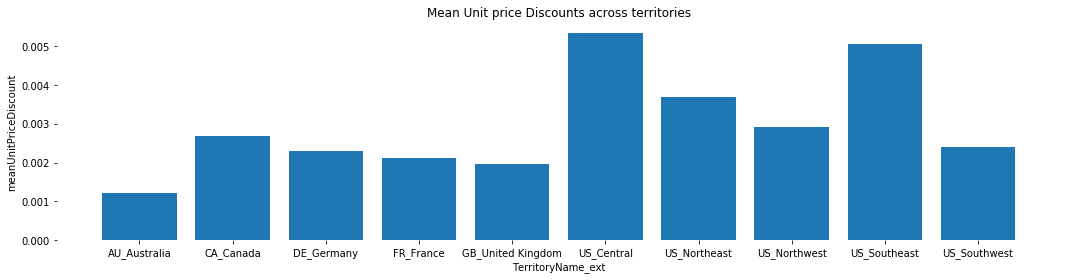

In [104]:
territory_fluc = SO[["TerritoryName_ext", "UnitPriceDiscount"]].groupby("TerritoryName_ext").agg({"UnitPriceDiscount" : "mean"}).reset_index().rename(columns = {"UnitPriceDiscount" : "meanUnitPriceDiscount"})
fplot.fancy_barplot(territory_fluc, "TerritoryName_ext", "meanUnitPriceDiscount", 
              ascending = True, limit = None, figsize = (18,4), title = "Mean Unit price Discounts across territories", 
              shiftparams = [-0.1, 2], fancylabels = False, sort_x = True)

As this barplot shows, there is (not statistically tested) a resemblance between the higher average discounts in the line totals for the Central and Southeast part of the US and their relatively higher variance in line total.

### 22. What are the most important sales reasons? 

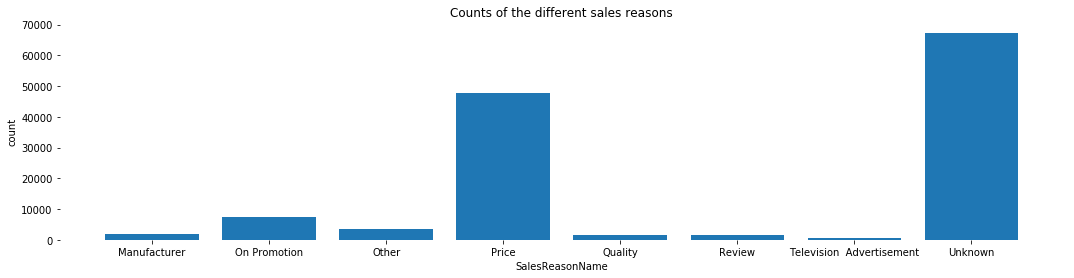

In [105]:
# Get the counts of the sales reasons
SalesReason_counts = SO["SalesReasonName"].value_counts(dropna = False).reset_index()
SalesReason_counts.columns = ["SalesReasonName", "count"]
SalesReason_counts.iloc[0,0] = "Unknown"

# generate plot 
fplot.fancy_barplot(SalesReason_counts, "SalesReasonName", "count", 
              ascending = True, limit = None, figsize = (18,4), title = "Counts of the different sales reasons", 
              shiftparams = [-0.1, 2], fancylabels = False, sort_x = True)

This shows that the price is really an important sales reason! In other words, the discounts are probably quite important for the customers. 

Also, this means that incentivizing customers to stay by giving price discounts will probably be a good idea. 

### 23. Relation between Ordering, due and shipment dates

Assumption for this part: we assume that the "Shipping date" is the same date as when the products arrives at the customer. 

###### 23.1 What is the mean time between the Order date and the Shipment date? Does this differ across territories? Does this differ across time? 

In [106]:
# Create time between order and shipment
SO["Days_Between_Order_and_Shipment"] = SO["ShipDate"] - SO["OrderDate"]
SO["Days_Between_Order_and_Shipment"] = pd.to_numeric(SO["Days_Between_Order_and_Shipment"].dt.days, downcast='integer')

# Calculate mean 
print("Mean time between order and shipment is {} days".format(round(np.mean(SO["Days_Between_Order_and_Shipment"]),2)))
print("Standard deviance of the time between order and shipment is {}".format(round(np.std(SO["Days_Between_Order_and_Shipment"]),2)))

Mean time between order and shipment is 7.0 days
Standard deviance of the time between order and shipment is 0.01


On average, it takes a week until the order is shipped to the customer. The standard deviation is very low, meaning that the company consistently has a time between ordering and shipment of 7 days. 

However, to show this in a different way, one could plot the daily times between ordering and shipment on a timeline. 

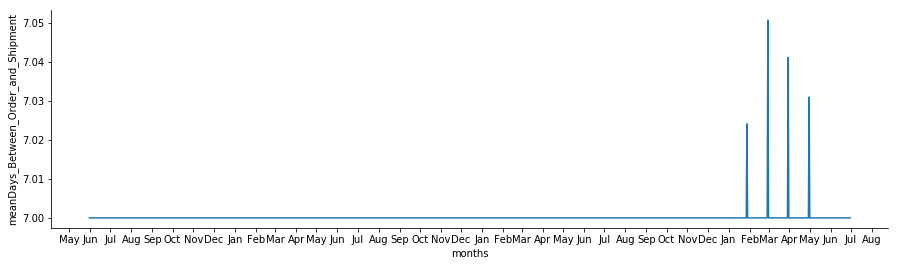

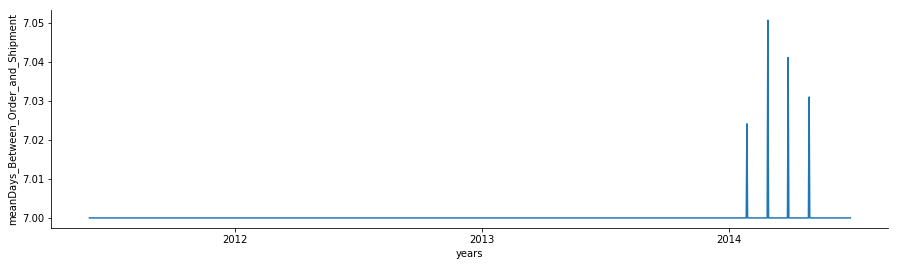

In [107]:
daily_days_between_order_and_shipment = SO[["OrderDate", "Days_Between_Order_and_Shipment"]].groupby("OrderDate").mean().reset_index().rename(columns = {"Days_Between_Order_and_Shipment": "meanDays_Between_Order_and_Shipment"})
fplot.plot_timeseries(x_values = daily_days_between_order_and_shipment['OrderDate'], 
                y_values = daily_days_between_order_and_shipment['meanDays_Between_Order_and_Shipment'], 
                x_formatting = 'months',
               y_label = "meanDays_Between_Order_and_Shipment")

# This plot generates yearly xticks
fplot.plot_timeseries(x_values = daily_days_between_order_and_shipment['OrderDate'], 
                y_values = daily_days_between_order_and_shipment['meanDays_Between_Order_and_Shipment'], 
                x_formatting = 'years',
               y_label = "meanDays_Between_Order_and_Shipment")

Interestingly, there seem to have been some problems with the deliveries in the last months! One can see this by the spikes in the mean days between ordering and shipment. This could have resulted in the customers to stop buying at Adventure Works. 

Let's have a closer look at the longest times between shipment to see how long they were. 

In [108]:
# Get the biggest number of days between Order and Shipment
Days_Between_Order_and_Shipment = list(SO["Days_Between_Order_and_Shipment"])
Days_Between_Order_and_Shipment.sort(reverse = True) 
Days_Between_Order_and_Shipment[0:10]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

All by all, a difference of 1 day seems to be ok. 

###### 23.2 What about the times between Due date and Shipment date?  

In [109]:
SO["Days_Between_Shipment_and_Due"] = SO["DueDate"] - SO["ShipDate"]
SO["Days_Between_Shipment_and_Due"] = pd.to_numeric(SO["Days_Between_Shipment_and_Due"].dt.days, downcast='integer')

# Calculate mean 
print("Mean time between order and shipment is {} days".format(round(np.mean(SO["Days_Between_Shipment_and_Due"]),2)))
print("Standard deviance of the time between order and shipment is {}".format(round(np.std(SO["Days_Between_Shipment_and_Due"]),2)))

Mean time between order and shipment is 5.0 days
Standard deviance of the time between order and shipment is 0.0


It seems to be the case that the shipments are always 5 days before their due. This looks great!

Since the standard deviance is 0, a plot doesn't really make sense to show. (since it is just a straight line) 

### 24. How are our products priced? 

In [110]:
median_price = statistics.median(list(Production_product["ListPrice"]))

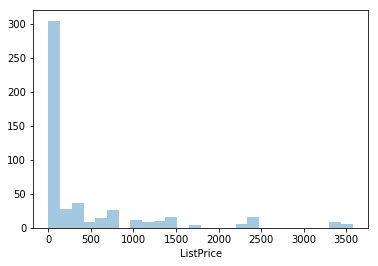

In [111]:
sns.distplot(Production_product["ListPrice"], kde = False)
plt.show()

There are clearly some different kinds of products. A lot of the products are really cheap, while others have different price ranges. Setting setting relevant price categories might be interesting for further analysis. 

In [112]:
Production_product[["ProductName", "ListPrice"]][Production_product["ListPrice"] > median_price].sort_values(by = "ListPrice").head()

,ProductName,ListPrice
420,HL Touring Seat/Saddle,52.64
417,HL Road Seat/Saddle,52.64
414,HL Mountain Seat/Saddle,52.64
385,"Short-Sleeve Classic Jersey, S",53.99
386,"Short-Sleeve Classic Jersey, M",53.99
